In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 7.0 MB/s 
     |████████████████████████████████| 9.5 MB 28.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import datetime as dt
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from math import sqrt
from pmdarima.arima.utils import ndiffs
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [4]:
px

<module 'plotly.express' from '/usr/local/lib/python3.7/dist-packages/plotly/express/__init__.py'>

In [5]:
#importing the dataset
covid_confirmed = pd.read_csv("project_dataset.confirmed_reduce.csv")

In [6]:
covid_death = pd.read_csv("project_dataset_death_reduce.csv")

In [7]:
covid_confirmed

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,...,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",4239,4268,4305,4336,4546,4645,4705,4770,4847,4879,4902,4970,4998,5075,5103,5154,5184,5198,5227,5257,5270,5327,5358,5376,5407,5440,5499,5554,5596,...,6897,6904,6907,6909,6910,6910,6914,6914,6918,6918,6920,6920,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049,7106,7113,7118,7118,7126,7135,7141,7142,7142,7142,7142,7150,7161,7172,7186,7186,7186,7206
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",13823,13955,14064,14187,14440,14656,14845,15052,15202,15327,15417,15572,15701,15841,16002,16176,16251,16346,16513,16653,16798,16981,17128,17256,17333,17496,17629,17779,17922,...,20921,20941,20966,20983,20993,20993,21035,21093,21107,21123,21131,21135,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489,21511,21535,21546,21554,21578,21593,21606,21620,21620,21620,21620,21661,21674,21684,21698,21698,21698,21724
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",1517,1528,1530,1533,1575,1597,1614,1634,1648,1658,1663,1679,1685,1696,1712,1723,1729,1730,1738,1760,1778,1793,1805,1827,1834,1882,1898,1920,1931,...,2299,2300,2302,2302,2302,2302,2307,2307,2307,2307,2308,2308,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326,2327,2328,2328,2328,2331,2331,2333,2334,2334,2334,2334,2337,2340,2343,2342,2342,2342,2343
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",1854,1863,1882,1885,1923,1944,1981,2015,2038,2051,2060,2090,2109,2113,2130,2144,2151,2162,2170,2188,2198,2212,2223,2223,2229,2247,2261,2271,2284,...,2593,2594,2596,2596,2597,2597,2604,2604,2604,2605,2607,2607,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656,2657,2656,2658,2659,2660,2662,2666,2664,2664,2664,2664,2665,2665,2665,2666,2666,2666,2667
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",4693,4729,4746,4771,4849,4898,4957,5018,5047,5066,5080,5134,5170,5219,5264,5292,5304,5308,5320,5376,5411,5439,5462,5473,5485,5517,5568,5612,5655,...,6607,6613,6616,6619,6621,6621,6635,6645,6651,6656,6660,6661,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816,6826,6829,6832,6832,6847,6856,6862,6864,6864,6864,6864,6887,6889,6894,6906,6906,6906,6916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",2138,2145,2159,2199,2216,2239,2260,2346,2348,2353,2447,2497,2502,2579,2605,2614,2685,2753,2769,2788,2847,2870,2870,2931,2981,2993,3020,3028,3078,...,3730,3732,3732,3732,3739,3741,3744,3753,3751,3751,3751,3755,3758,3760,3762,3765,3765,3765,3769,3772,3770,3775,3776,3776,3776,3780,3780,3781,3781,3784,3784,3784,3784,3785,3785,3785,3787,3787,3787,3789
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",1558,1569,1570,1589,1597,1618,1668,1693,1693,1708,1744,1764,1774,1794,1806,1813,1817,1833,1843,1852,1874,1887,1887,1900,1913,1925,1948,1957,1959,...,2181,2183,2183,2183,2195,2204,2209,2211,2217,2217,2217,2229,2232,2234,2237,2239,2239,2239,2244,2249,2250,

In [8]:
covid_death

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,...,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,50,50,50,50,50,50,50,50,53,54,55,55,55,55,55,55,55,55,55,55,61,61,62,62,62,65,67,69,...,107,107,107,107,107,107,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,109,109,110,110,110,110,110,110,110,110,110,110,111,111,111,112,112,112,113
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,169,169,169,169,169,171,171,171,173,173,173,175,175,177,179,182,182,182,183,184,188,188,189,189,189,216,217,225,...,305,305,306,306,306,306,307,307,307,308,308,308,308,309,309,309,310,310,310,310,310,310,310,310,310,310,310,310,310,311,311,311,311,311,311,312,312,312,312,312
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,33,33,33,33,33,35,35,35,35,35,35,35,35,36,36,36,36,36,36,36,36,37,38,38,38,40,40,40,...,56,56,56,56,56,56,56,57,57,57,57,57,57,56,56,56,56,56,56,56,56,58,58,58,58,58,58,58,58,59,59,59,59,59,59,59,59,59,59,59
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,46,46,46,46,46,48,48,48,48,48,48,48,48,47,47,47,47,47,47,47,48,48,48,48,48,51,51,51,...,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,63,63,63,63,63,67,72,75,77,77,77,79,80,80,83,83,83,83,83,83,86,86,86,86,86,94,95,98,...,135,135,135,135,135,135,136,136,137,137,137,137,137,137,137,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",23464,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,6,6,6,...,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",20226,7,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9,9,9,10,10,10,12,12,12,12,12,12,12,...,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",7805,19,19,19,19,21,21,21,21,21,21,21,23,23,23,23,23,23,23,24,24,24,25,25,25,25,25,25,25,...,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26


In [9]:
# I will drop the column dont we dont need for the analysis: for this project the column of interest are the Province_ state, date of confirmed case
covid_confirmed = covid_confirmed.drop(columns= ['UID',	'iso2',	'iso3',	'code3',	'FIPS',	'Admin2', 'Country_Region', 'Lat',	'Long_',	'Combined_Key'])

In [10]:
covid_confirmed

,Province_State,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,...,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21
0,Alabama,4239,4268,4305,4336,4546,4645,4705,4770,4847,4879,4902,4970,4998,5075,5103,5154,5184,5198,5227,5257,5270,5327,5358,5376,5407,5440,5499,5554,5596,5596,5669,5683,5723,5753,5811,5824,5856,5869,5881,...,6897,6904,6907,6909,6910,6910,6914,6914,6918,6918,6920,6920,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049,7106,7113,7118,7118,7126,7135,7141,7142,7142,7142,7142,7150,7161,7172,7186,7186,7186,7206
1,Alabama,13823,13955,14064,14187,14440,14656,14845,15052,15202,15327,15417,15572,15701,15841,16002,16176,16251,16346,16513,16653,16798,16981,17128,17256,17333,17496,17629,17779,17922,17922,18126,18211,18344,18418,18494,18568,18668,18723,18763,...,20921,20941,20966,20983,20993,20993,21035,21093,21107,21123,21131,21135,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489,21511,21535,21546,21554,21578,21593,21606,21620,21620,21620,21620,21661,21674,21684,21698,21698,21698,21724
2,Alabama,1517,1528,1530,1533,1575,1597,1614,1634,1648,1658,1663,1679,1685,1696,1712,1723,1729,1730,1738,1760,1778,1793,1805,1827,1834,1882,1898,1920,1931,1931,1951,1956,1966,1981,1989,1994,2002,2008,2008,...,2299,2300,2302,2302,2302,2302,2307,2307,2307,2307,2308,2308,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326,2327,2328,2328,2328,2331,2331,2333,2334,2334,2334,2334,2337,2340,2343,2342,2342,2342,2343
3,Alabama,1854,1863,1882,1885,1923,1944,1981,2015,2038,2051,2060,2090,2109,2113,2130,2144,2151,2162,2170,2188,2198,2212,2223,2223,2229,2247,2261,2271,2284,2284,2307,2309,2319,2321,2327,2331,2334,2339,2346,...,2593,2594,2596,2596,2597,2597,2604,2604,2604,2605,2607,2607,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656,2657,2656,2658,2659,2660,2662,2666,2664,2664,2664,2664,2665,2665,2665,2666,2666,2666,2667
4,Alabama,4693,4729,4746,4771,4849,4898,4957,5018,5047,5066,5080,5134,5170,5219,5264,5292,5304,5308,5320,5376,5411,5439,5462,5473,5485,5517,5568,5612,5655,5655,5713,5720,5745,5768,5842,5871,5908,5915,5920,...,6607,6613,6616,6619,6621,6621,6635,6645,6651,6656,6660,6661,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816,6826,6829,6832,6832,6847,6856,6862,6864,6864,6864,6864,6887,6889,6894,6906,6906,6906,6916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,Wyoming,2138,2145,2159,2199,2216,2239,2260,2346,2348,2353,2447,2497,2502,2579,2605,2614,2685,2753,2769,2788,2847,2870,2870,2931,2981,2993,3020,3028,3078,3078,3116,3146,3151,3161,3199,3219,3233,3238,3257,...,3730,3732,3732,3732,3739,3741,3744,3753,3751,3751,3751,3755,3758,3760,3762,3765,3765,3765,3769,3772,3770,3775,3776,3776,3776,3780,3780,3781,3781,3784,3784,3784,3784,3785,3785,3785,3787,3787,3787,3789
3338,Wyoming,1558,1569,1570,1589,1597,1618,1668,1693,1693,1708,1744,1764,1774,1794,1806,1813,1817,1833,1843,1852,1874,1887,1887,1900,1913,1925,1948,1957,1959,1960,1963,1968,1975,1981,1984,1984,1984,1983,1988,...,2181,2183,2183,2183,2195,2204,2209,2211,2217,2217,2217,2229,2232,2234,2237,2239,2239,2239,2244,2249,2250,2251,2246,2246,2246,2252,2261,2263,2264,2266,2266,2266,2266,2272,2279,2287,2289,2289,2289,2290
3339,Wyoming,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,

In [11]:
#drop column
covid_death = covid_death.drop(columns= ['UID',	'iso2',	'iso3',	'code3',	'FIPS',	'Admin2', 'Country_Region', 'Population', 'Lat',	'Long_',	'Combined_Key'])

In [12]:
covid_death

,Province_State,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,...,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21
0,Alabama,50,50,50,50,50,50,50,50,53,54,55,55,55,55,55,55,55,55,55,55,61,61,62,62,62,65,67,69,69,69,69,69,70,71,74,76,77,77,77,...,107,107,107,107,107,107,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,109,109,110,110,110,110,110,110,110,110,110,110,111,111,111,112,112,112,113
1,Alabama,169,169,169,169,169,171,171,171,173,173,173,175,175,177,179,182,182,182,183,184,188,188,189,189,189,216,217,225,224,224,224,224,228,228,233,234,227,227,227,...,305,305,306,306,306,306,307,307,307,308,308,308,308,309,309,309,310,310,310,310,310,310,310,310,310,310,310,310,310,311,311,311,311,311,311,312,312,312,312,312
2,Alabama,33,33,33,33,33,35,35,35,35,35,35,35,35,36,36,36,36,36,36,36,36,37,38,38,38,40,40,40,40,40,40,40,40,42,43,44,45,45,45,...,56,56,56,56,56,56,56,57,57,57,57,57,57,56,56,56,56,56,56,56,56,58,58,58,58,58,58,58,58,59,59,59,59,59,59,59,59,59,59,59
3,Alabama,46,46,46,46,46,48,48,48,48,48,48,48,48,47,47,47,47,47,47,47,48,48,48,48,48,51,51,51,51,51,52,52,52,52,52,52,53,53,53,...,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
4,Alabama,63,63,63,63,63,67,72,75,77,77,77,79,80,80,83,83,83,83,83,83,86,86,86,86,86,94,95,98,98,98,100,100,101,105,109,111,112,112,112,...,135,135,135,135,135,135,136,136,137,137,137,137,137,137,137,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,Wyoming,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,7,7,7,...,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
3338,Wyoming,7,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9,9,9,10,10,10,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
3339,Wyoming,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
3340,Wyoming,19,19,19,19,21,21,21,21,21,21,21,23,23,23,23,23,23,23,24,24,24,25,25,25,25,25,25,25,25,25,25,25,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26


In [13]:
#It is not to pratical to have date as column instead we want them as row in their commun column name called Date
# we will merged all the row from the same Province, aggregate them , sum them and we will finally tranpose the data frame
covid_confirmed = covid_confirmed.groupby(by='Province_State').aggregate(np.sum).T
covid_death = covid_death.groupby(by='Province_State').aggregate(np.sum).T

In [14]:
covid_confirmed


Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1/1/21,365747,47019,0,530267,229442,2365024,337161,185708,58064,49,29252,1323315,677589,103,7326,22397,141077,963389,517773,282980,230108,265261,315275,24902,280219,375178,528621,415302,218386,445019,81555,167716,227046,45932,535043,144142,995816,539545,92770,122,700380,291209,113909,653260,77054,87949,307507,99164,586802,1782956,276612,7412,2036,354766,246752,87820,522523,44409
1/2/21,369458,47821,0,539150,231442,2415246,339172,190120,58873,49,29509,1354833,685122,103,7326,22448,142199,975352,523090,283895,230119,273970,315275,25245,283171,384181,538121,417832,220277,448387,81944,168262,228871,46614,541202,145379,1011665,558437,92891,122,714673,296343,116348,661901,77932,87949,312718,99829,604132,1801181,281654,7689,2041,358755,246752,89327,523652,44573
1/3/21,371934,48118,0,556384,233475,2452262,341250,190120,59484,49,29764,1365436,690900,103,7326,22560,142507,979821,526071,284715,230119,276825,321058,25592,285319,387662,538121,420544,222061,451605,82381,169000,231614,47376,545450,146394,1023897,564924,93041,122,721481,304375,117745,666341,78169,87949,321669,100532,608297,1816886,283473,7793,2042,363765,255396,91058,526245,44875
1/4/21,374095,48382,0,561542,234781,2490518,343435,194636,60333,49,29904,1376692,696063,103,7344,22602,143305,984880,529688,286356,234069,279142,322181,25967,287802,392568,543611,423688,223677,454015,82664,169585,233032,47870,547247,147315,1035139,570111,93240,122,727423,307091,118453,671190,78805,92708,325472,100643,612250,1831146,285633,7873,2055,367536,256435,91886,527871,45257
1/5/21,379593,48582,0,567474,238888,2529480,346893,196968,61100,49,30166,1392123,706154,103,7357,22757,144843,991719,533083,288298,233901,280835,326648,26565,289758,397202,546642,425261,225444,458230,83378,171033,235455,48662,554400,148499,1048281,575396,93494,122,735003,308600,119488,680080,79319,93852,328073,101076,617649,1864173,288951,8038,2083,371913,258767,93162,531890,45569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6/3/21,545028,70408,0,882691,341889,3792962,545002,347748,108957,49,49041,2329867,1125017,103,8193,36402,192630,1383647,745690,371765,315767,459540,472617,67986,460194,707523,993952,601881,318048,607774,112129,223517,325031,98840,1017044,203330,2103768,1003989,110098,183,1103380,453400,202247,1208879,138873,151936,593628,124242,863620,2959171,406825,24240,3512,676041,438544,162111,674939,60549
6/4/21,545585,70469,0,883037,342142,3794129,545769,347891,109005,49,49068,2329867,1125512,103,8204,36471,192795,1384283,746135,371862,316059,460049,472981,68058,460339,707723,994506,602134,318189,608463,112260,223558,325392,98877,1017118,203472,2104539,1004669,110151,183,1104001,453552,202680,1209492,138949,151992,593727,124261,863840,2961257,407113,24252,3512,676300,439263,162232,675150,60628
6/5/21,545585,70469,0,883314,342345,3794927,546500,347891,109070,49,49068,2332867,1125854,103,8204,36535,192795,1384823,746554,371956,316059,460412,472981,68155,460471,707940,994935,602428,318189,608970,112260,223558,325392,98877,1017695,203472,2105375,1004669,110178,183,1104380,453552,202995,1209894,139004,151992,593948,124261,863840,2962395,407419,24252,3512,676586,440057,162232,675150,60628
6/6/21,545585,70469,0,883821,342433,3795580,

In [15]:
covid_death.head()

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1/1/21,4872,206,0,9015,3711,26504,4873,5995,1065,0,788,21673,10958,3,122,289,1436,17978,9468,3898,2892,2623,7488,352,5942,12423,13018,5382,4816,5747,961,1668,3143,759,19160,2502,38155,6748,1316,2,13728,2489,1477,16245,1521,1944,5296,1488,6907,28359,1269,136,23,5081,3461,1361,5254,438
1/2/21,4872,215,0,9061,3729,26696,4912,6099,1072,0,792,21890,10960,3,122,289,1448,18217,9562,3946,2893,2698,7488,358,5967,12502,13306,5436,4840,5751,971,1669,3148,769,19187,2534,38273,6892,1317,2,13880,2527,1492,16273,1526,1957,5385,1501,6970,28442,1294,139,23,5117,3461,1373,5256,438
1/3/21,4873,215,0,9061,3749,26788,4934,6099,1080,0,794,21987,10964,3,122,289,1448,18322,9625,3946,2893,2723,7537,359,5994,12610,13306,5489,4871,5770,972,1672,3180,780,19208,2551,38415,6910,1317,2,14014,2547,1500,16331,1545,1974,5469,1513,7025,28496,1301,140,23,5124,3459,1376,5261,438
1/4/21,4878,218,0,9064,3800,27160,4944,6168,1085,0,797,22090,10971,3,122,289,1459,18412,9735,3992,2911,2749,7585,361,6027,12671,13391,5502,4884,5772,975,1682,3206,781,19225,2574,38599,6941,1319,2,14178,2552,1506,16432,1555,1992,5484,1513,7168,28570,1305,144,24,5132,3482,1396,5269,438
1/5/21,4886,218,0,9317,3836,27684,4991,6192,1093,0,801,22188,11072,3,123,289,1471,18562,9800,3999,3006,2772,7635,369,6082,12734,13608,5520,4975,5987,1005,1692,3235,792,19382,2594,38743,6996,1336,2,14313,2571,1550,16631,1562,2005,5498,1513,7267,28808,1312,149,24,5191,3541,1442,5366,464


In [16]:
# I changed the column name to date and reset tha index
covid_confirmed.index.name= "Date"
covid_confirmed = covid_confirmed.reset_index()
covid_death.index.name= "Date"
covid_death = covid_death.reset_index()

In [17]:
covid_death

Province_State,Date,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1/1/21,4872,206,0,9015,3711,26504,4873,5995,1065,0,788,21673,10958,3,122,289,1436,17978,9468,3898,2892,2623,7488,352,5942,12423,13018,5382,4816,5747,961,1668,3143,759,19160,2502,38155,6748,1316,2,13728,2489,1477,16245,1521,1944,5296,1488,6907,28359,1269,136,23,5081,3461,1361,5254,438
1,1/2/21,4872,215,0,9061,3729,26696,4912,6099,1072,0,792,21890,10960,3,122,289,1448,18217,9562,3946,2893,2698,7488,358,5967,12502,13306,5436,4840,5751,971,1669,3148,769,19187,2534,38273,6892,1317,2,13880,2527,1492,16273,1526,1957,5385,1501,6970,28442,1294,139,23,5117,3461,1373,5256,438
2,1/3/21,4873,215,0,9061,3749,26788,4934,6099,1080,0,794,21987,10964,3,122,289,1448,18322,9625,3946,2893,2723,7537,359,5994,12610,13306,5489,4871,5770,972,1672,3180,780,19208,2551,38415,6910,1317,2,14014,2547,1500,16331,1545,1974,5469,1513,7025,28496,1301,140,23,5124,3459,1376,5261,438
3,1/4/21,4878,218,0,9064,3800,27160,4944,6168,1085,0,797,22090,10971,3,122,289,1459,18412,9735,3992,2911,2749,7585,361,6027,12671,13391,5502,4884,5772,975,1682,3206,781,19225,2574,38599,6941,1319,2,14178,2552,1506,16432,1555,1992,5484,1513,7168,28570,1305,144,24,5132,3482,1396,5269,438
4,1/5/21,4886,218,0,9317,3836,27684,4991,6192,1093,0,801,22188,11072,3,123,289,1471,18562,9800,3999,3006,2772,7635,369,6082,12734,13608,5520,4975,5987,1005,1692,3235,792,19382,2594,38743,6996,1336,2,14313,2571,1550,16631,1562,2005,5498,1513,7267,28808,1312,149,24,5191,3541,1442,5366,464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,6/3/21,11188,369,0,17653,5842,63345,6603,8245,1668,0,1136,36973,20900,3,139,501,2101,25265,13657,6065,5081,7077,10605,837,9626,17893,20485,7530,7324,9544,1627,2249,5599,1354,26253,4273,53357,13130,1546,2,19980,7316,2683,27295,2515,2715,9739,2020,12472,51633,2308,255,28,11216,5821,2807,7923,720
154,6/4/21,11198,369,0,17673,5845,63401,6611,8246,1674,0,1136,36973,20942,3,139,501,2101,25282,13661,6067,5085,7086,10615,838,9630,17903,20511,7538,7325,9554,1632,2249,5600,1355,26265,4280,53416,13151,1546,2,19980,7316,2686,27325,2516,2717,9744,2022,12476,51676,2311,256,28,11222,5836,2813,7954,720
155,6/5/21,11198,369,0,17698,5846,63441,6613,8246,1677,0,1136,36973,20986,3,139,502,2101,25314,13685,6068,5085,7091,10615,839,9639,17907,20588,7554,7325,9558,1632,2249,5600,1355,26273,4280,53429,13151,1547,2,19980,7316,2691,27343,2518,2717,9752,2022,12476,51701,2311,256,28,11229,5836,2813,7954,720
156,6/6/21,11198,369,0,17700,5846,63557,6613,8246,1677,0,1136,36973,20986,3,139,505,2101,25352,13685,6072,5085,7091,10615,839,9645,17911,20588,7558,7325,9557,1632,2249,5600,1355,26279,4280,53462,13151,1547,2,19980,7316,2694,27348,2519,2717,9754,2022,12476,51719,2311,256,28,11236,5836,2813,7954,720


In [18]:
#melt the data frame from a wide to a long format
covid_confirmed_melt = covid_confirmed.melt(id_vars='Date').copy()
covid_confirmed_melt

,Date,Province_State,value
0,1/1/21,Alabama,365747
1,1/2/21,Alabama,369458
2,1/3/21,Alabama,371934
3,1/4/21,Alabama,374095
4,1/5/21,Alabama,379593
...,...,...,...
9159,6/3/21,Wyoming,60549
9160,6/4/21,Wyoming,60628
9161,6/5/21,Wyoming,60628
9162,6/6/21,Wyoming,60628


In [19]:
# rename the column
covid_confirmed_melt.rename(columns={'value': 'Confirmed'}, inplace=True)

In [20]:
covid_confirmed_melt

,Date,Province_State,Confirmed
0,1/1/21,Alabama,365747
1,1/2/21,Alabama,369458
2,1/3/21,Alabama,371934
3,1/4/21,Alabama,374095
4,1/5/21,Alabama,379593
...,...,...,...
9159,6/3/21,Wyoming,60549
9160,6/4/21,Wyoming,60628
9161,6/5/21,Wyoming,60628
9162,6/6/21,Wyoming,60628


In [21]:
df_confirmed = covid_confirmed_melt.copy()
df_confirmed

,Date,Province_State,Confirmed
0,1/1/21,Alabama,365747
1,1/2/21,Alabama,369458
2,1/3/21,Alabama,371934
3,1/4/21,Alabama,374095
4,1/5/21,Alabama,379593
...,...,...,...
9159,6/3/21,Wyoming,60549
9160,6/4/21,Wyoming,60628
9161,6/5/21,Wyoming,60628
9162,6/6/21,Wyoming,60628


In [22]:
#The date value are string and we need to convert them to date time
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_confirmed.set_index('Date', inplace=True)

In [23]:
df_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9164 entries, 2021-01-01 to 2021-06-07
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Province_State  9164 non-null   object
 1   Confirmed       9164 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 214.8+ KB


In [24]:
# Confirmed column is cumulative and we want them to be in a daily basis
df_confirmed['Daily_confirmed'] = df_confirmed.groupby(['Province_State'])['Confirmed'].diff()

In [25]:
df_confirmed

,Province_State,Confirmed,Daily_confirmed
Date,,,
2021-01-01,Alabama,365747,NaN
2021-01-02,Alabama,369458,3711.0
2021-01-03,Alabama,371934,2476.0
2021-01-04,Alabama,374095,2161.0
2021-01-05,Alabama,379593,5498.0
...,...,...,...
2021-06-03,Wyoming,60549,102.0
2021-06-04,Wyoming,60628,79.0
2021-06-05,Wyoming,60628,0.0


In [26]:
df_confirmed = df_confirmed.dropna()


In [27]:
df_confirmed

,Province_State,Confirmed,Daily_confirmed
Date,,,
2021-01-02,Alabama,369458,3711.0
2021-01-03,Alabama,371934,2476.0
2021-01-04,Alabama,374095,2161.0
2021-01-05,Alabama,379593,5498.0
2021-01-06,Alabama,384184,4591.0
...,...,...,...
2021-06-03,Wyoming,60549,102.0
2021-06-04,Wyoming,60628,79.0
2021-06-05,Wyoming,60628,0.0


In [28]:
# As we want to analyse the covid-19 US we will drop the province_state column and group the confirmed case by date.
df_conf = df_confirmed.drop(columns= ['Province_State'])

In [29]:
df_conf

,Confirmed,Daily_confirmed
Date,,
2021-01-02,369458,3711.0
2021-01-03,371934,2476.0
2021-01-04,374095,2161.0
2021-01-05,379593,5498.0
2021-01-06,384184,4591.0
...,...,...
2021-06-03,60549,102.0
2021-06-04,60628,79.0
2021-06-05,60628,0.0


In [30]:
df_conf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9106 entries, 2021-01-02 to 2021-06-07
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Confirmed        9106 non-null   int64  
 1   Daily_confirmed  9106 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 213.4 KB


In [31]:
#I will merge all the row with the same date, aggregate and sum them
covid_DF = df_conf.groupby(by='Date').aggregate(np.sum)

In [32]:
covid_DF

,Confirmed,Daily_confirmed
Date,,
2021-01-02,20554622,300462.0
2021-01-03,20763475,208853.0
2021-01-04,20947480,184005.0
2021-01-05,21182522,235042.0
2021-01-06,21438159,255637.0
...,...,...
2021-06-03,33326437,19074.0
2021-06-04,33343297,16860.0
2021-06-05,33357205,13908.0


In [33]:
# drop Confirmed column as we don't need for the analysis
covid_df = covid_DF.drop(columns= ['Confirmed'])
covid_df

,Daily_confirmed
Date,
2021-01-02,300462.0
2021-01-03,208853.0
2021-01-04,184005.0
2021-01-05,235042.0
2021-01-06,255637.0
...,...
2021-06-03,19074.0
2021-06-04,16860.0
2021-06-05,13908.0


In [34]:
#Covid death data manipulation_ I applied the same step as Covid confirmed data frame
covid_death_melt = covid_death.melt(id_vars='Date').copy()
covid_death_melt

,Date,Province_State,value
0,1/1/21,Alabama,4872
1,1/2/21,Alabama,4872
2,1/3/21,Alabama,4873
3,1/4/21,Alabama,4878
4,1/5/21,Alabama,4886
...,...,...,...
9159,6/3/21,Wyoming,720
9160,6/4/21,Wyoming,720
9161,6/5/21,Wyoming,720
9162,6/6/21,Wyoming,720


In [35]:
covid_death_melt.rename(columns={'value': 'Death'}, inplace=True)


In [36]:
df_death = covid_death_melt.copy()
df_death

,Date,Province_State,Death
0,1/1/21,Alabama,4872
1,1/2/21,Alabama,4872
2,1/3/21,Alabama,4873
3,1/4/21,Alabama,4878
4,1/5/21,Alabama,4886
...,...,...,...
9159,6/3/21,Wyoming,720
9160,6/4/21,Wyoming,720
9161,6/5/21,Wyoming,720
9162,6/6/21,Wyoming,720


In [37]:
#1)The date value are string and we need to convert them to date time. 
# 2)Put the date column as an index.
df_death['Date'] = pd.to_datetime(df_death['Date'])
df_death.set_index('Date', inplace=True)

In [38]:
# Death column is comulative and we want them to be in a daily basis
df_death['Daily_death'] = df_death.groupby(['Province_State'])['Death'].diff()

In [39]:
df_death = df_death.dropna()

In [40]:
df_death = df_death.drop(columns= ['Province_State'])

In [41]:
df_death

,Death,Daily_death
Date,,
2021-01-02,4872,0.0
2021-01-03,4873,1.0
2021-01-04,4878,5.0
2021-01-05,4886,8.0
2021-01-06,4994,108.0
...,...,...
2021-06-03,720,0.0
2021-06-04,720,0.0
2021-06-05,720,0.0


In [42]:
covid_D = df_death.groupby(by='Date').aggregate(np.sum)
covid_D

,Death,Daily_death
Date,,
2021-01-02,356940,2512.0
2021-01-03,358394,1454.0
2021-01-04,360484,2090.0
2021-01-05,364197,3713.0
2021-01-06,368103,3906.0
...,...,...
2021-06-03,596491,601.0
2021-06-04,597001,510.0
2021-06-05,597377,376.0


In [43]:
covid_d = covid_D.drop(columns= ['Death'])
covid_d

,Daily_death
Date,
2021-01-02,2512.0
2021-01-03,1454.0
2021-01-04,2090.0
2021-01-05,3713.0
2021-01-06,3906.0
...,...
2021-06-03,601.0
2021-06-04,510.0
2021-06-05,376.0


In [44]:
# Merged daily confirmed and daily date on the date
Covid_merg = covid_df.merge(right=covid_d, how= 'left', on=['Date'])

In [45]:
Covid_merg

,Daily_confirmed,Daily_death
Date,,
2021-01-02,300462.0,2512.0
2021-01-03,208853.0,1454.0
2021-01-04,184005.0,2090.0
2021-01-05,235042.0,3713.0
2021-01-06,255637.0,3906.0
...,...,...
2021-06-03,19074.0,601.0
2021-06-04,16860.0,510.0
2021-06-05,13908.0,376.0


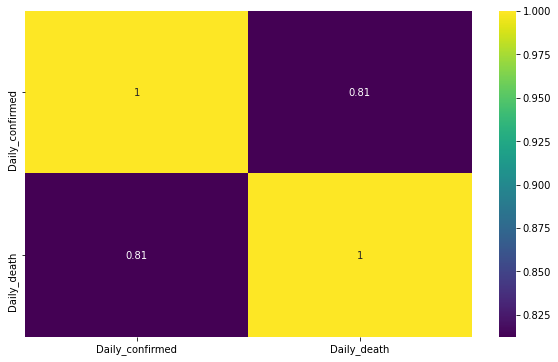

In [ ]:
# plot the heatmap to check for correlation
plt.figure(figsize=(10, 6))
sns.heatmap(Covid_merg.corr(), annot=True, cmap='viridis')

In [ ]:
Covid_merg.shape #covid_confirmed_melt.plot()

(157, 2)

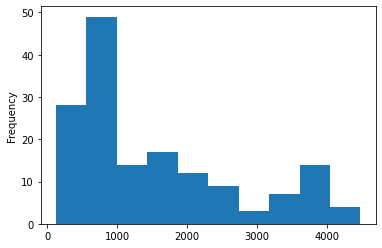

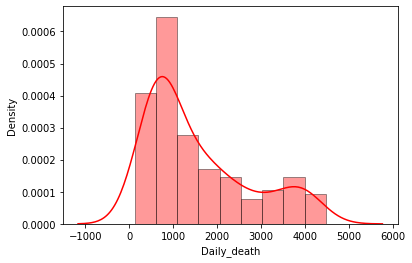

In [ ]:
#histogram
Covid_merg['Daily_death'].plot.hist()
plt.show()
#density plot
sns.distplot(a=Covid_merg.Daily_death, color='red', hist_kws={"edgecolor":'black'})
plt.show()

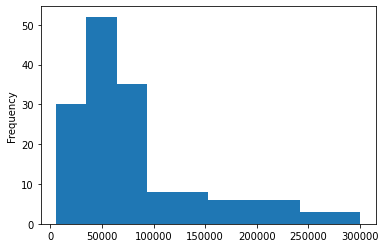

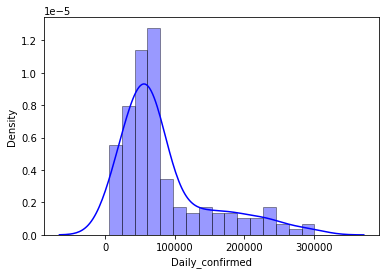

In [ ]:
#histogram
Covid_merg['Daily_confirmed'].plot.hist()
plt.show()
# density plot
sns.distplot(a=Covid_merg.Daily_confirmed, color='blue', hist_kws={"edgecolor":'black'})
plt.show()


In [ ]:
Covid_merg['Daily_death'].describe()

count     157.000000
mean     1551.108280
std      1180.441256
min       126.000000
25%       683.000000
50%      1023.000000
75%      2107.000000
max      4477.000000
Name: Daily_death, dtype: float64

In [ ]:
Covid_merg['Daily_confirmed'].describe()

count       157.000000
mean      83591.949045
std       65013.092013
min        5395.000000
25%       43220.000000
50%       62498.000000
75%       95250.000000
max      300462.000000
Name: Daily_confirmed, dtype: float64

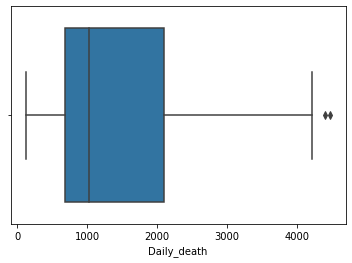

In [ ]:
# plot the boxplot to check for outlier
sns.boxplot(x= Covid_merg.Daily_death)

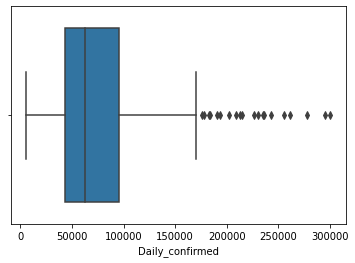

In [ ]:
sns.boxplot(x= Covid_merg.Daily_confirmed)

***#checking stationarity with  ADF (Augmented Dickey Fuller Statistical ) test***

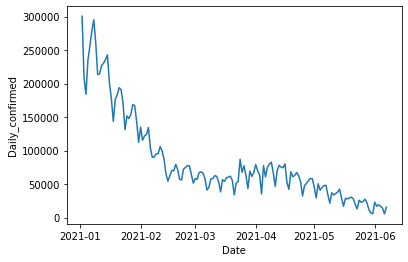

In [44]:
#plot graph (Daily confirmed cases)
plt.xlabel('Date')
plt.ylabel('Daily_confirmed')
plt.plot(Covid_merg.Daily_confirmed)

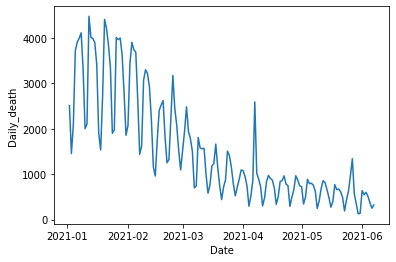

In [45]:
#plot graph (Daily death cases)
plt.xlabel('Date')
plt.ylabel('Daily_death')
plt.plot(Covid_merg.Daily_death)

In [46]:
from statsmodels.tsa.stattools import adfuller

In [48]:
# Ho: Null hypothesis " time series is non stationary"
# H1 time series is stationary 
def adfuller_test(Covid_merg):
  result = adfuller(Covid_merg)
  labels = ['ADF Test statistic','p-value', '#Lags Used','Number of Observations used for ADF']
  for value, label in zip(result, labels):
    print(label+' : '+str(value))
  if result[1] <= 0.05:
      print('strong evidence against the null hypothesis(Ho), reject Ho: the data does not have a unit root and is stationary ')
  else:
      print ('weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary')


In [49]:
#check stationarity for Daily confirmed cases
adfuller_test(Covid_merg['Daily_confirmed'])

ADF Test statistic : -2.553206316787138
p-value : 0.10305928414333415
#Lags Used : 14
Number of Observations used for ADF : 142
weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary


In [ ]:
#check stationarity for Daily death cases
adfuller_test(Covid_merg['Daily_death'])

ADF Test statistic : -2.0481070303643145
p-value : 0.26588602204047895
#Lags Used : 13
Number of Observations used for ADF : 143
weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary


# Model analysis Daily confirmed cases

1) Apply transformation to penalize higher values more than smaller values

In [47]:
# Daily confirmed
Covid_daily_conf = Covid_merg.drop(columns=['Daily_death'])
Covid_daily_conf

,Daily_confirmed
Date,
2021-01-02,300462.0
2021-01-03,208853.0
2021-01-04,184005.0
2021-01-05,235042.0
2021-01-06,255637.0
...,...
2021-06-03,19074.0
2021-06-04,16860.0
2021-06-05,13908.0


In [51]:
from pmdarima.utils import diff, diff_inv

In [52]:
diff_1 = Covid_daily_conf.diff()
diff_1.dropna(inplace = True)

In [53]:
diff_1.head()

,Daily_confirmed
Date,
2021-01-03,-91609.0
2021-01-04,-24848.0
2021-01-05,51037.0
2021-01-06,20595.0
2021-01-07,22700.0


In [54]:
adfuller_test(diff_1)

ADF Test statistic : -2.084242603082708
p-value : 0.2508977518233392
#Lags Used : 14
Number of Observations used for ADF : 141
weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary


In [55]:
diff_2 = diff_1.diff()
diff_2.dropna(inplace = True)

In [56]:
diff_2.head()

,Daily_confirmed
Date,
2021-01-04,66761.0
2021-01-05,75885.0
2021-01-06,-30442.0
2021-01-07,2105.0
2021-01-08,-5780.0


In [57]:
adfuller_test(diff_2)

ADF Test statistic : -7.334413404755486
p-value : 1.1061575072826967e-10
#Lags Used : 13
Number of Observations used for ADF : 141
strong evidence against the null hypothesis(Ho), reject Ho: the data does not have a unit root and is stationary 


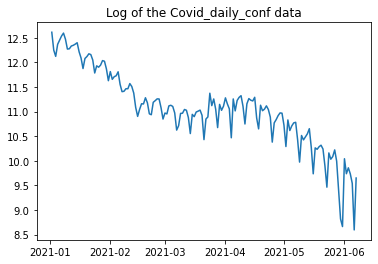

In [58]:
# Log Transformation
ts_log = np.log(Covid_daily_conf)
plt.title('Log of the Covid_daily_conf data')
plt.plot(ts_log)
plt.show()

In [59]:
ts_log.head()

,Daily_confirmed
Date,
2021-01-02,12.613077
2021-01-03,12.249386
2021-01-04,12.122718
2021-01-05,12.367520
2021-01-06,12.451514


In [60]:
adfuller_test(ts_log.dropna())

ADF Test statistic : -0.61666067564955
p-value : 0.867172782559917
#Lags Used : 14
Number of Observations used for ADF : 142
weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary


In [61]:
# First difference
ts_log_diff_1 = ts_log - ts_log.shift()
ts_log_diff_1.dropna(inplace = True)


In [ ]:
ts_log_diff_1

,Daily_confirmed
Date,
2021-01-03,-0.363691
2021-01-04,-0.126668
2021-01-05,0.244801
2021-01-06,0.083994
2021-01-07,0.085074
...,...
2021-06-03,0.120244
2021-06-04,-0.123382
2021-06-05,-0.192480


In [62]:
# test for stationarity
adfuller_test(ts_log_diff_1)

ADF Test statistic : -1.8147867574913437
p-value : 0.3731455829197215
#Lags Used : 14
Number of Observations used for ADF : 141
weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary


In [63]:
#2nd difference
ts_log_diff_2 = ts_log_diff_1 - ts_log_diff_1.shift()
ts_log_diff_2.dropna(inplace=True)

In [ ]:
 ts_log_diff_2

,Daily_confirmed
Date,
2021-01-04,0.237023
2021-01-05,0.371469
2021-01-06,-0.160807
2021-01-07,0.001080
2021-01-08,-0.026061
...,...
2021-06-03,0.425174
2021-06-04,-0.243626
2021-06-05,-0.069098


In [ ]:
# test for stationarity
adfuller_test(ts_log_diff_2)

ADF Test statistic : -7.365277986495487
p-value : 9.271441446331528e-11
#Lags Used : 13
Number of Observations used for ADF : 141
strong evidence against the null hypothesis(Ho), reject Ho: the data does not have a unit root and is stationary 


**Decomposition**

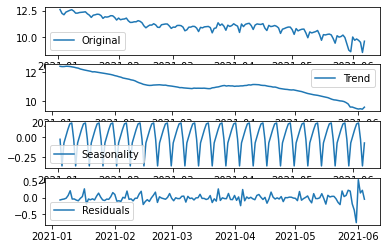

<Figure size 432x288 with 0 Axes>

In [64]:
# Check the component of the timeseries data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

In [ ]:
# After decomposition,The trend and seasonality are separated out from data and we can model the residuals(irregularity that is present in the data)
#check for stationarity
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
adfuller_test(ts_log_decompose)

ADF Test statistic : -7.070567575872909
p-value : 4.94973377208319e-10
#Lags Used : 12
Number of Observations used for ADF : 138
strong evidence against the null hypothesis(Ho), reject Ho: the data does not have a unit root and is stationary 


In [65]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
%matplotlib inline

In [66]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

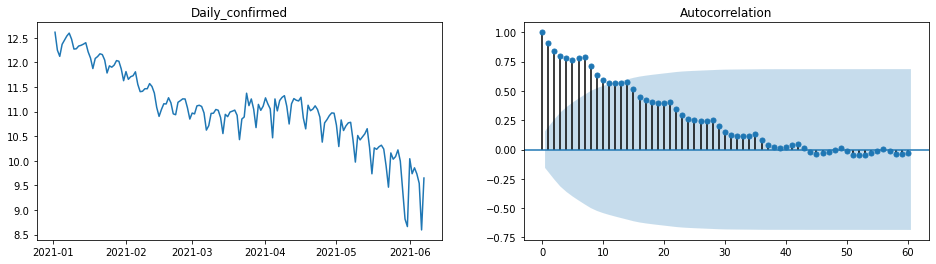

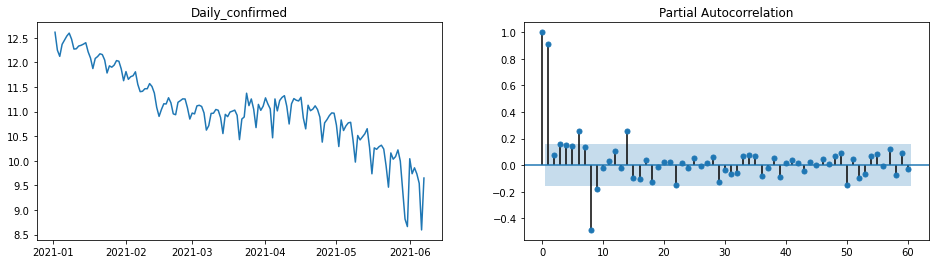

In [ ]:
# acf and pcf for the original data( before differencing)
#acf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(ts_log.Daily_confirmed)
ax1.set_title("Daily_confirmed")
plot_acf(ts_log.Daily_confirmed, lags=60, ax=ax2)
plt.show()
#pacf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(ts_log.Daily_confirmed)
ax1.set_title("Daily_confirmed")
plot_pacf(ts_log.Daily_confirmed, lags=60, ax=ax2)
plt.show()

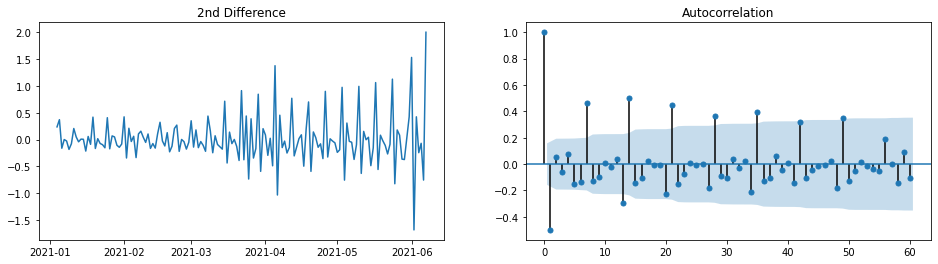

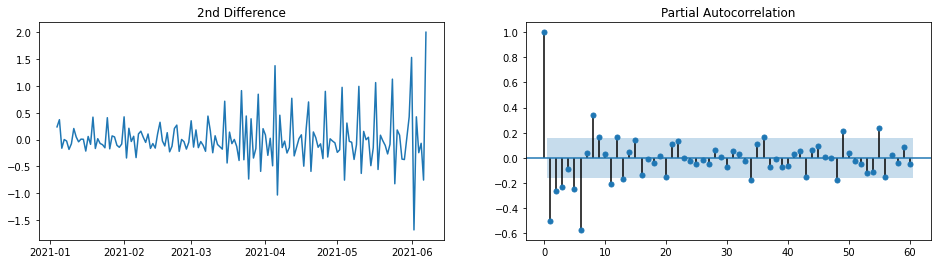

In [ ]:
#acf and pcf after the differencing
#acf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(ts_log_diff_2)
ax1.set_title("2nd Difference")
plot_acf(ts_log_diff_2, lags=60, ax=ax2)
plt.show()
#pacf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(ts_log_diff_2)
ax1.set_title("2nd Difference")
plot_pacf(ts_log_diff_2, lags=60, ax=ax2)
plt.show()

In [ ]:
# we used ndiffs to have the number for Daily_confirmed
ndiffs(ts_log, test="adf")
# d= 1  (number of differencing require to make the series stationary)

1

In [67]:
from pmdarima import auto_arima

In [68]:
# Impliment Autoarima to check p,d,q value
model_auto = auto_arima(ts_log_diff_2, trace =True, suppress_warnings=True)
model_auto.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=191.848, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=141.774, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=189.914, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=127.597, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=116.222, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=115.258, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=99.799, Time=0.18 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=2.958, Time=0.66 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=42.305, Time=0.55 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-15.439, Time=0.83 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=52.535, Time=0.60 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  155
Model:               SARIMAX(5, 0, 3)   Log Likelihood                  37.410
Date:                Wed, 28 Jul 2021   AIC                            -56.820
Time:                        15:46:58   BIC                            -29.430
Sample:                             0   HQIC                           -45.695
                                - 155                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0744      0.090      0.825      0.409      -0.102       0.251
ar.L2         -0.5506      0.100     -5.482      0.000      -0.747      -0.354
ar.L3         -0.4803      0.126     -3.818      0.000      -0.727      -0.234
ar.L4         -0.3075      0.121     -2.542      0.011      -0.545      -0.070
ar.L5         -0.5347      0.096     -5.569      0.000      -0.723      -0.347
ma.L1         -1.9089      0.095    -20.032      0.000      -2.096      -1.722
ma.L2          1.7072      0.169     10.123      0.000       1.377       2.038
ma.L3         -0.7881      0.109     -7.262      0.000      -1.001      -0.575
sigma2         0.0333      0.003     12.320      0.000       0.028       0.039
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               175.96
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               6.15   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From auto_arima, the p, d, q with minimize AIC score is order=(5,0,3)

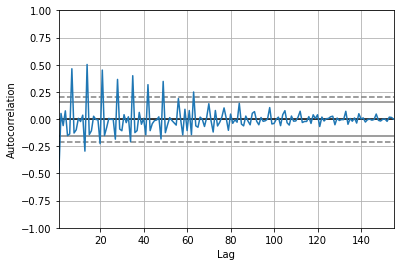

In [151]:
# Arima
#Autocorrelation analysis
autocorrelation_plot(ts_log_diff_2)
pyplot.show()

In [ ]:
#check p,d,q parameters manually
import itertools
p=d=q = range(0, 6)
pdq = itertools.product(p,d,q)
for param in pdq:
    try:
        mod = ARIMA(diff_2.Daily_confirmed, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

In [69]:
from pandas import Series
#
def difference(dataset, interval):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
 # invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# split into train and test sets
def run_rolling_forecasting(Covid_daily_conf, training_percentage = 0.80):
    X = Covid_daily_conf['Daily_confirmed']
    #X = X.values
    X = X.astype('float32')
    train_size = int(len(X) * training_percentage)
    train, test = X[:train_size], X[train_size:]
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        diff = difference(history,interval=1)
        model = ARIMA(diff, order=(5,0,3))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        yhat=inverse_difference(history,yhat)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print("%d/%d Predicted=%f, Expected=%f" % (t, len(test), yhat, obs))
    # metric evaluation
    mae = mean_absolute_error(test, predictions)
    rmse = sqrt(mean_squared_error(test, predictions))
    return test, predictions, rmse, mae
test, predictions, rmse, mae = \
    run_rolling_forecasting(Covid_daily_conf, training_percentage=0.80)
print("Test MAE: %.3f; RMSE: %.3f" % (mae, rmse))

0/32 Predicted=43657.552447, Expected=48137.000000
1/32 Predicted=30698.494495, Expected=33676.000000
2/32 Predicted=29333.425109, Expected=21430.000000
3/32 Predicted=28259.570531, Expected=36804.000000
4/32 Predicted=34968.838026, Expected=33644.000000
5/32 Predicted=34085.369543, Expected=35839.000000
6/32 Predicted=38361.243065, Expected=38076.000000
7/32 Predicted=34238.511506, Expected=42259.000000
8/32 Predicted=24845.737825, Expected=28854.000000
9/32 Predicted=22259.075769, Expected=16887.000000
10/32 Predicted=22775.599704, Expected=28622.000000
11/32 Predicted=28312.735639, Expected=27790.000000
12/32 Predicted=26723.345819, Expected=29293.000000
13/32 Predicted=30751.944051, Expected=30208.000000
14/32 Predicted=28112.689638, Expected=27952.000000
15/32 Predicted=16849.906406, Expected=19799.000000
16/32 Predicted=12701.750229, Expected=12866.000000
17/32 Predicted=13937.012050, Expected=25819.000000
18/32 Predicted=23427.171264, Expected=22739.000000
19/32 Predicted=25043.

In [70]:
#Mean absolute percentage error(MAPE)
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1))*100

Text(0.5, 1.0, 'True vs predicted values Arima Model')

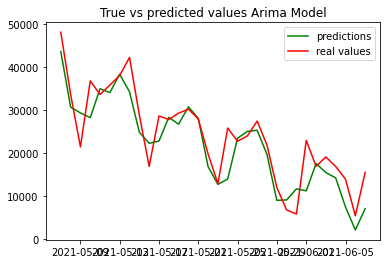

In [72]:
pred = pd.Series(predictions, index=test.index)
#Plotting results
f,ax=plt.subplots()
plt.plot(pred,c='green', label= 'predictions')
plt.plot(test, c='red',label='real values')
plt.legend()
plt.title('True vs predicted values Arima Model')

In [159]:
np.mean(pred)

array([21842.05027864])

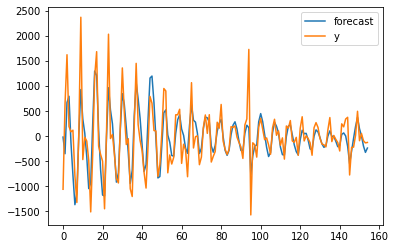

In [154]:
model_fit.plot_predict(dynamic = False)
plt.show()

                              ARMA Model Results                              
Dep. Variable:        Daily_confirmed   No. Observations:                  125
Model:                     ARMA(5, 3)   Log Likelihood               -1368.650
Method:                       css-mle   S.D. of innovations          12952.145
Date:                Wed, 28 Jul 2021   AIC                           2757.300
Time:                        15:51:45   BIC                           2785.583
Sample:                    01-02-2021   HQIC                          2768.790
                         - 05-06-2021                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.884e+04   1.24e+05      0.796      0.426   -1.44e+05    3.42e+05
ar.L1.Daily_confirmed     1.8200      0.144     12.682      0.000       1.539       2.101
ar.L2.Da

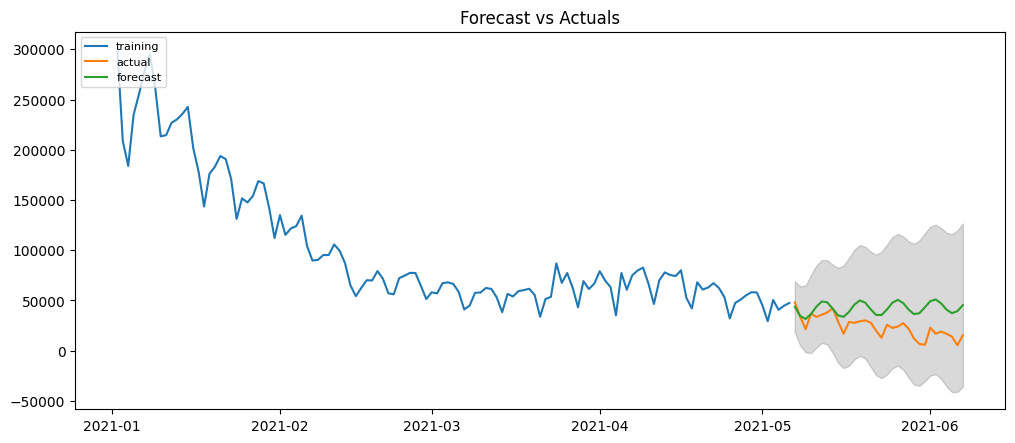

In [74]:

# Create Training and Test
train=Covid_daily_conf.iloc[:int(Covid_daily_conf.shape[0]*0.80)]
test=Covid_daily_conf.iloc[int(Covid_daily_conf.shape[0]*0.80):]

#Forecast
model = ARIMA(train, order=(5, 0, 3))  
fitted = model.fit(disp=-1)
print(fitted.summary())
fc, se,conf= fitted.forecast(32, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Linear regression and support vector machine

In [48]:
Covid_daily_ML =Covid_daily_conf
Covid_daily_ML

,Daily_confirmed
Date,
2021-01-02,300462.0
2021-01-03,208853.0
2021-01-04,184005.0
2021-01-05,235042.0
2021-01-06,255637.0
...,...
2021-06-03,19074.0
2021-06-04,16860.0
2021-06-05,13908.0


In [76]:
#convert the timeseries to supervise machine learning. We assume that the ouput of the day after depends on that of the previous days
Covid_daily_ML['1_daybefor'] = Covid_daily_ML['Daily_confirmed'].shift(+1)
Covid_daily_ML['2_daybefor'] = Covid_daily_ML['Daily_confirmed'].shift(+2)
Covid_daily_ML['3_daybefor'] = Covid_daily_ML['Daily_confirmed'].shift(+3)
Covid_daily_ML

,Daily_confirmed,1_daybefor,2_daybefor,3_daybefor
Date,,,,
2021-01-02,300462.0,NaN,NaN,NaN
2021-01-03,208853.0,300462.0,NaN,NaN
2021-01-04,184005.0,208853.0,300462.0,NaN
2021-01-05,235042.0,184005.0,208853.0,300462.0
2021-01-06,255637.0,235042.0,184005.0,208853.0
...,...,...,...,...
2021-06-03,19074.0,16913.0,22943.0,5776.0
2021-06-04,16860.0,19074.0,16913.0,22943.0
2021-06-05,13908.0,16860.0,19074.0,16913.0


In [77]:
Covid_daily_ML = Covid_daily_ML.dropna()
Covid_daily_ML

,Daily_confirmed,1_daybefor,2_daybefor,3_daybefor
Date,,,,
2021-01-05,235042.0,184005.0,208853.0,300462.0
2021-01-06,255637.0,235042.0,184005.0,208853.0
2021-01-07,278337.0,255637.0,235042.0,184005.0
2021-01-08,295257.0,278337.0,255637.0,235042.0
2021-01-09,260967.0,295257.0,278337.0,255637.0
...,...,...,...,...
2021-06-03,19074.0,16913.0,22943.0,5776.0
2021-06-04,16860.0,19074.0,16913.0,22943.0
2021-06-05,13908.0,16860.0,19074.0,16913.0


Linear regression

In [78]:
# input value "1_daybefor"	"2_daybefor" will be use to predict daily confirmed cases
x1, x2, x3,y= Covid_daily_ML['1_daybefor'],Covid_daily_ML['2_daybefor'],Covid_daily_ML['3_daybefor'],Covid_daily_ML['Daily_confirmed']
x1,x2, x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2, x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3),axis=1)


In [79]:
final_x

array([[184005., 208853., 300462.],
       [235042., 184005., 208853.],
       [255637., 235042., 184005.],
       [278337., 255637., 235042.],
       [295257., 278337., 255637.],
       [260967., 295257., 278337.],
       [213415., 260967., 295257.],
       [214664., 213415., 260967.],
       [226967., 214664., 213415.],
       [230301., 226967., 214664.],
       [235766., 230301., 226967.],
       [242780., 235766., 230301.],
       [201858., 242780., 235766.],
       [177931., 201858., 242780.],
       [143598., 177931., 201858.],
       [176216., 143598., 177931.],
       [183261., 176216., 143598.],
       [193856., 183261., 176216.],
       [190760., 193856., 183261.],
       [170759., 190760., 193856.],
       [131198., 170759., 190760.],
       [151677., 131198., 170759.],
       [147626., 151677., 131198.],
       [153961., 147626., 151677.],
       [168804., 153961., 147626.],
       [166613., 168804., 153961.],
       [142459., 166613., 168804.],
       [112152., 142459., 16

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = final_x[:-20],final_x[-20:],y[:-20],y[-20:]

In [81]:
lin_model=LinearRegression(normalize=True)

In [82]:
lin_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [83]:
lin_pred = lin_model.predict(X_test)


In [84]:
#metric calculations
rmse = math.sqrt(mean_squared_error(y_test, lin_pred))
mse = mean_squared_error(y_test, lin_pred)
mae = mean_absolute_error(y_test, lin_pred)
print("RMSE: {}".format(rmse))
print( f"MAE: {mae}")

##Mean absolute percentage error(MAPE)
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1))*100
Mape= mape(y_test, lin_pred)
print( f"MAPE: {Mape}")

RMSE: 7057.643124994877
MAE: 6096.118235360291
MAPE: 46.65744078103141


Text(0.5, 1.0, 'True vs predicted values Linear Regression Model')

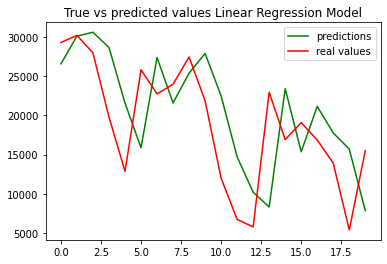

In [86]:
#plotting results
from pandas import Series
f,ax=plt.subplots()
plt.plot(lin_pred,c='green', label= 'predictions')
plt.plot(y_test, c='red',label='real values')
plt.legend()
plt.title('True vs predicted values Linear Regression Model')

Support vector machine

In [87]:
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.001)
svm_model = svm.fit(X_train,y_train)

In [88]:
svm_predict = svm_model.predict(X_test)
svm_predict

array([63247.06351704, 63247.6759403 , 63247.60068101, 63247.45991561,
       63247.1961618 , 63247.18704611, 63247.34770414, 63247.07505257,
       63247.38352588, 63247.38981731, 63247.13403468, 63247.15359409,
       63247.15753026, 63247.15475151, 63247.17040658, 63247.11871434,
       63247.24819425, 63247.16002483, 63247.16592134, 63247.15263751])

In [89]:
#metric cumputations
rmse = math.sqrt(mean_squared_error(svm_predict, y_test))
mae = mean_absolute_error(svm_predict, y_test)
Mapsv = mape(y_test, svm_predict)
print("RMSE: {}".format(rmse))
print( f"MAE: {mae}")
print( f"MAPE: {Mapsv}")

RMSE: 45029.85735035777
MAE: 44394.39975855824
MAPE: 336.11585326847177


Text(0.5, 1.0, 'True vs predicted values SVM model')

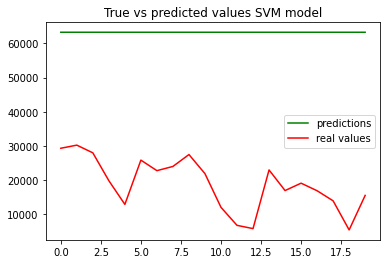

In [90]:
#Plotting results
f,ax=plt.subplots()
plt.plot(svm_predict,c='green', label= 'predictions')
plt.plot(y_test, c='red',label='real values')
plt.legend()
plt.title('True vs predicted values SVM model')

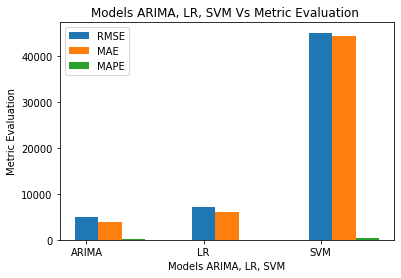

In [150]:
#plot metric results

w=0.2
x = ["ARIMA", "LR", "SVM"]
RMSE = [5040.95, 7057.64, 45029.86 ]
MAE =  [3860.64, 6096.12, 44394.40]
MAPE = [67.83, 46.66, 336.12 ]
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]

plt.bar(bar1, RMSE,w,label="RMSE")
plt.bar(bar2, MAE,w,label="MAE")
plt.bar(bar3, MAPE,w,label="MAPE")

plt.xlabel("Models ARIMA, LR, SVM")
plt.ylabel("Metric Evaluation")
plt.title("Models ARIMA, LR, SVM Vs Metric Evaluation ")
plt.xticks(bar1, x)
plt.legend()
plt.show()


Model Analysis Daily Death

1) Apply transformation to penalize higher values more than smaller values

In [91]:
# Daily confirmed
Covid_daily_death = Covid_merg.drop(columns=['Daily_confirmed'])
Covid_daily_death

,Daily_death
Date,
2021-01-02,2512.0
2021-01-03,1454.0
2021-01-04,2090.0
2021-01-05,3713.0
2021-01-06,3906.0
...,...
2021-06-03,601.0
2021-06-04,510.0
2021-06-05,376.0


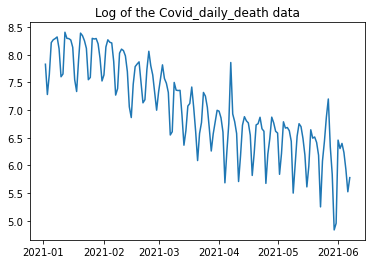

In [92]:
# Log Transformation
ts_log_death = np.log(Covid_daily_death)
plt.title('Log of the Covid_daily_death data')
plt.plot(ts_log_death)
plt.show()

In [93]:
ts_log_death.head()

,Daily_death
Date,
2021-01-02,7.828835
2021-01-03,7.282074
2021-01-04,7.644919
2021-01-05,8.219595
2021-01-06,8.270269


In [113]:
adfuller_test(ts_log_death)

ADF Test statistic : -0.6848656238486311
p-value : 0.8506308332052233
#Lags Used : 14
Number of Observations used for ADF : 142
weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary


In [115]:
dif_death = ts_log_death.diff()
dif_death.dropna(inplace=True)

In [116]:
adfuller_test(dif_death)

ADF Test statistic : -4.289100385106187
p-value : 0.00046391932803536577
#Lags Used : 14
Number of Observations used for ADF : 141
strong evidence against the null hypothesis(Ho), reject Ho: the data does not have a unit root and is stationary 


In [94]:
#adfuller_test
adfuller_test(Covid_daily_death)

ADF Test statistic : -2.0481070303643185
p-value : 0.2658860220404772
#Lags Used : 13
Number of Observations used for ADF : 143
weak evidence against the null hypothesis(Ho), fail to reject Ho: the data has a root and is non stationary


In [95]:
#applying difference
diff_death1 = Covid_daily_death.diff()
diff_death1.dropna(inplace=True)

In [ ]:
adfuller_test(diff_death1)

ADF Test statistic : -4.693058067474913
p-value : 8.671627414758273e-05
#Lags Used : 13
Number of Observations used for ADF : 142
strong evidence against the null hypothesis(Ho), reject Ho: the data does not have a unit root and is stationary 


The dataset is stationary after applying the first difference

**Decomposition**

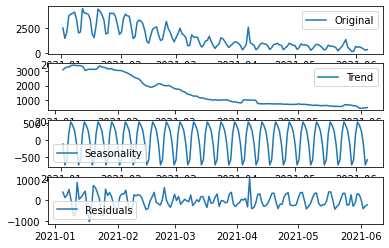

<Figure size 432x288 with 0 Axes>

In [96]:
# Check the component of the timeseries data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition1 = seasonal_decompose(Covid_daily_death)

trend_d = decomposition1.trend
seasonal_d = decomposition1.seasonal
residual_d = decomposition1.resid

plt.subplot(411)
plt.plot(Covid_daily_death, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_d, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_d,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_d, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

In [97]:
# After decomposition,The trend and seasonality are separated out from data and we can model the residuals(irregularity that is present in the data)
#check for seasonality
death_decompose = residual_d
death_decompose.dropna(inplace=True)
adfuller_test(death_decompose)

ADF Test statistic : -8.217673128521984
p-value : 6.557071908546697e-13
#Lags Used : 12
Number of Observations used for ADF : 138
strong evidence against the null hypothesis(Ho), reject Ho: the data does not have a unit root and is stationary 


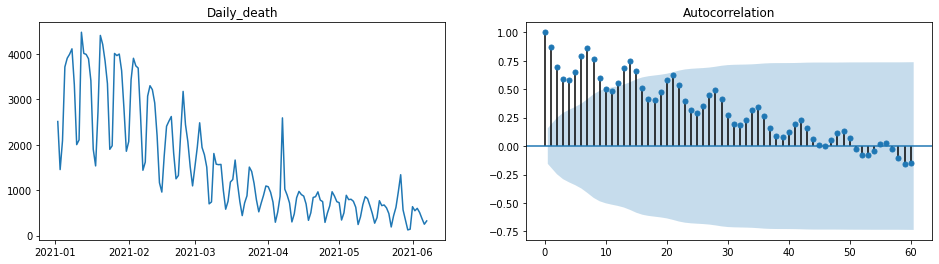

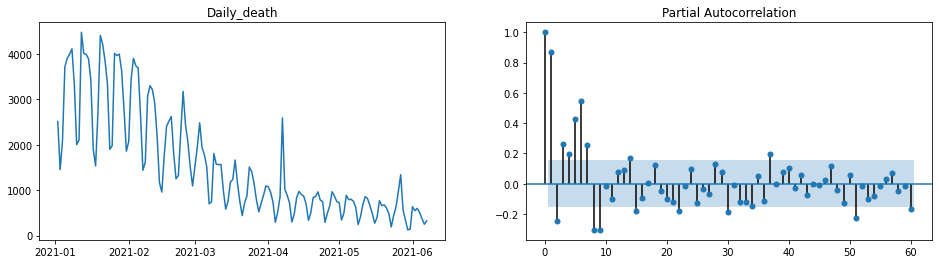

In [98]:
# acf and pcf for the original data( before differencing)
#acf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(Covid_daily_death.Daily_death)
ax1.set_title("Daily_death")
plot_acf(Covid_daily_death.Daily_death, lags=60, ax=ax2)
plt.show()
#pacf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(Covid_daily_death.Daily_death)
ax1.set_title("Daily_death")
plot_pacf(Covid_daily_death.Daily_death, lags=60, ax=ax2)
plt.show()

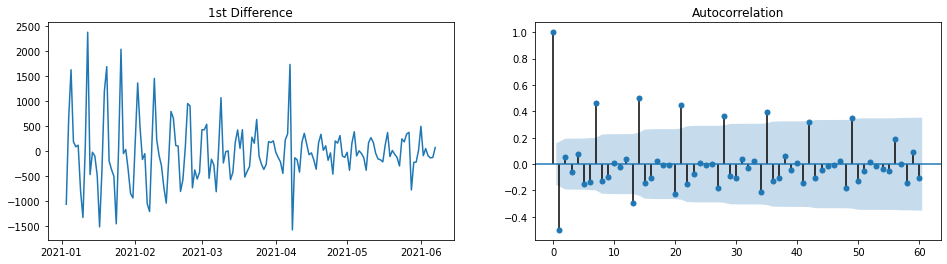

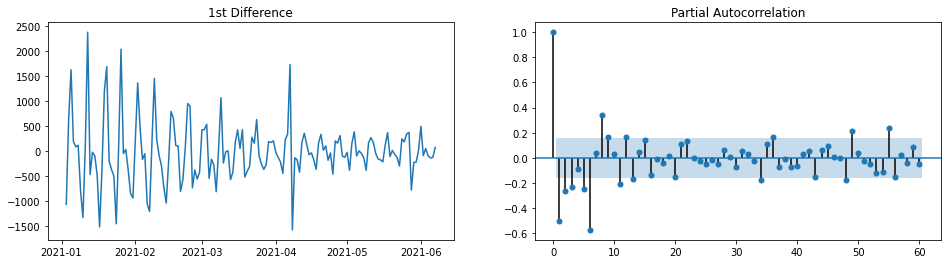

In [99]:
#acf and pcf after the differencing
#acf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff_death1)
ax1.set_title("1st Difference")
plot_acf(ts_log_diff_2, lags=60, ax=ax2)
plt.show()
#pacf
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff_death1)
ax1.set_title("1st Difference")
plot_pacf(ts_log_diff_2, lags=60, ax=ax2)
plt.show()

In [100]:
# we used ndiffs to have the number for Daily_death
ndiffs(Covid_daily_death, test="adf")
# d= 1  (number of differencing require to make the series stationary)

1

In [117]:
# Impliment Autoarima to check p,d,q value
model_auto = auto_arima(dif_death, trace =True, suppress_warnings=True)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=70.748, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=183.586, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=183.994, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=182.746, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=181.731, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=107.975, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=111.393, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=33.174, Time=0.52 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=49.682, Time=0.57 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=30.233, Time=0.71 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(2, 0, 4)   Log Likelihood                  -7.117
Date:                Wed, 28 Jul 2021   AIC                             30.233
Time:                        16:40:37   BIC                             54.632
Sample:                             0   HQIC                            40.143
                                - 156                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0111      0.003     -4.400      0.000      -0.016      -0.006
ar.L1          1.2405      0.010    122.067      0.000       1.221       1.260
ar.L2         -0.9948      0.008   -126.474      0.000      -1.010      -0.979
ma.L1         -2.1042      0.076    -27.714      0.000      -2.253      -1.955
ma.L2          2.1029      0.170     12.387      0.000       1.770       2.436
ma.L3         -0.9629      0.192     -5.022      0.000      -1.339      -0.587
ma.L4          0.0663      0.097      0.681      0.496      -0.124       0.257
sigma2         0.0603      0.008      7.988      0.000       0.046       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                18.35
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.20
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From auto_arima, the p, d, q with minimize AIC score is order=(2,0,3)

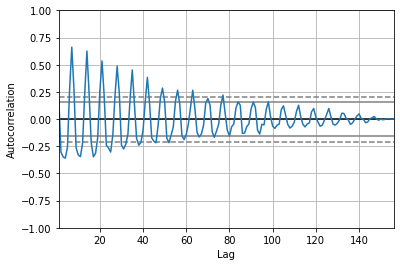

In [ ]:
# Arima
#Autocorrelation analysis
autocorrelation_plot(diff_death1)
pyplot.show()

In [108]:
import itertools
p=d=q = range(0, 6)
pdq = itertools.product(p,d,q)
for param in pdq:
    try:
        mod = ARIMA(diff_death1.Daily_death, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:2441.446530366159
ARIMA(0, 0, 1) - AIC:2433.301112007871
ARIMA(0, 0, 2) - AIC:2392.343835965265
ARIMA(0, 0, 3) - AIC:2382.104480591529
ARIMA(0, 0, 4) - AIC:2379.201058906339
ARIMA(0, 1, 0) - AIC:2502.6108395932597
ARIMA(0, 1, 1) - AIC:2433.864690282769
ARIMA(0, 1, 2) - AIC:2425.2311252376467
ARIMA(0, 1, 3) - AIC:2381.003512970328
ARIMA(0, 1, 4) - AIC:2370.6122554245353
ARIMA(0, 1, 5) - AIC:2370.6531526183617
ARIMA(0, 2, 0) - AIC:2619.1663790988864
ARIMA(0, 2, 1) - AIC:2494.500554065671
ARIMA(0, 2, 2) - AIC:2431.498397391642
ARIMA(0, 2, 3) - AIC:2422.203842920679
ARIMA(0, 2, 4) - AIC:2380.2331360051057
ARIMA(0, 2, 5) - AIC:2391.3813017808116
ARIMA(1, 0, 0) - AIC:2438.5408133090273
ARIMA(1, 0, 3) - AIC:2383.8145523413077
ARIMA(1, 0, 4) - AIC:2367.35656085389
ARIMA(1, 0, 5) - AIC:2365.489771590809
ARIMA(1, 1, 0) - AIC:2498.653375722143
ARIMA(1, 2, 0) - AIC:2582.2958463669092
ARIMA(1, 2, 2) - AIC:2430.2157897648785
ARIMA(1, 2, 4) - AIC:2375.3203438018454
ARIMA(1, 2, 5)

In [103]:
def difference(dataset, interval=1):
    #index =list(dataset.index)
	  diff =list()
	  for i in range(interval, len(dataset)):
		  value = dataset[i] - dataset[i - interval]
		  diff.append(value)
	  return Series(diff)
 
 # invert differenced value
def inverse_difference(history, yhat, interval=1):
	  return yhat + history[-interval]

In [141]:
# split into train and test sets
X = Covid_daily_death.Daily_death
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
    # walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    diff = difference(history,interval=1)
    model = ARIMA(diff, order=(2,0,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    yhat=inverse_difference(history,yhat)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
print("Predicted", yhat,  "Expected=", obs)

Predicted [233.51960204] Expected= 324.0
